# New Data Analysis

## Import Lib

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Get All Data

In [2]:
def get_all_data():
    files_name = '_BMS_influxdb_data.csv'
    files_path = []
    for root, dirs, files in os.walk('../data/'):
        for file in files:
            if file.endswith(files_name):
                files_path.append(os.path.join(root, file))

    data = [pd.read_csv(file, index_col=[0]) for file in files_path]
    df = pd.concat(data, ignore_index=True)
    df.sort_values('timestamp', inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.reset_index(drop=True, inplace=True)

    return df[['timestamp', 'SOH', 'System voltage', 'System Current', 'SOC']]

In [3]:
all_data = get_all_data()
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33239030 entries, 0 to 33239029
Data columns (total 5 columns):
 #   Column          Dtype              
---  ------          -----              
 0   timestamp       datetime64[ns, UTC]
 1   SOH             int64              
 2   System voltage  int64              
 3   System Current  int64              
 4   SOC             int64              
dtypes: datetime64[ns, UTC](1), int64(4)
memory usage: 1.2 GB


all_data.to_csv('../data/all_dataset.csv')

## Data Preprocessing

In [4]:
def calculate_sum_to_hourly(data, column):
    return data[column].resample('60min').apply(lambda x: x.sum() * (1/3600))


def resample_with_change_rate(df):
    df = df[df['System voltage'] != 0]

    df['Power'] = df['System voltage'] * df['System Current'] 

    df['Voltage_change'] = df['System voltage'].diff()
    df['Current_change'] = df['System Current'].diff()
    df['Power_change'] = df['Power'].diff()
    df['SOC_change'] = df['SOC'].diff()

    df.set_index('timestamp', inplace=True)
    df_resampled = df.resample('60min').mean()
    
    df_resampled['Coulomb_Counting'] = calculate_sum_to_hourly(df, 'System Current')
    df_resampled['Energy'] = calculate_sum_to_hourly(df, 'Power')
    
    df_resampled['SOH'] = df['SOH'].resample('60min').last()
    # df_resampled = df_resampled.fillna(0)
    df_resampled.reset_index(inplace=True)
    
    return df_resampled[df_resampled['SOH'] > 0]

In [5]:
df = resample_with_change_rate(all_data)

/tmp/ipykernel_549730/1001414301.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Power'] = df['System voltage'] * df['System Current']
/tmp/ipykernel_549730/1001414301.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Voltage_change'] = df['System voltage'].diff()
/tmp/ipykernel_549730/1001414301.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [6]:
df =df.dropna()

/home/genailab/miniconda3/envs/esa/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/genailab/miniconda3/envs/esa/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


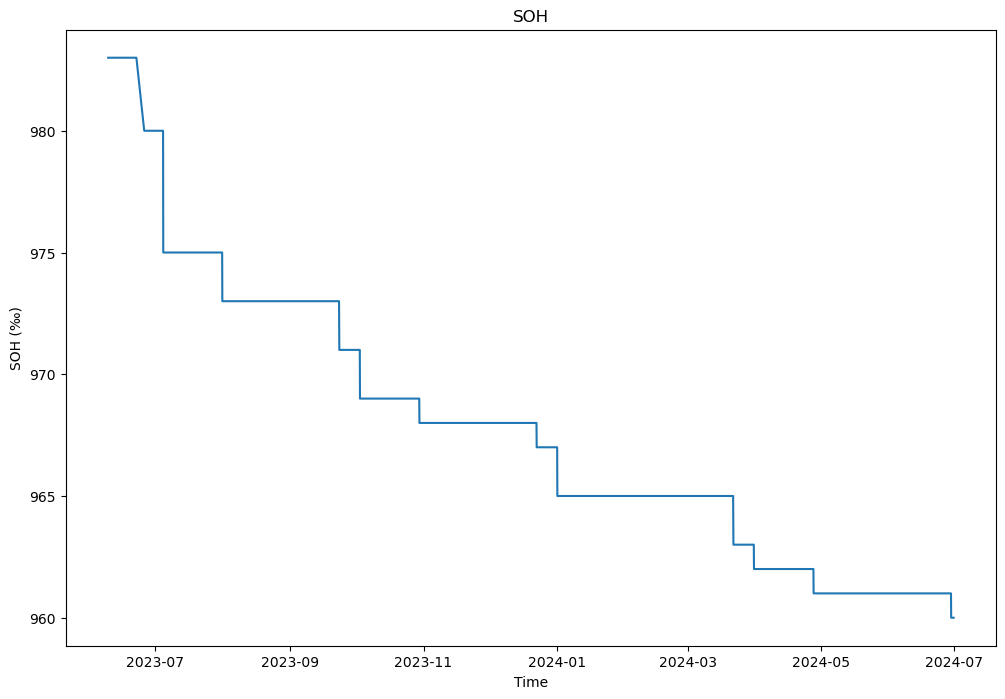

In [7]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='timestamp', y='SOH', data=df)
plt.title('SOH')
plt.ylabel('SOH (‰)')
plt.xlabel('Time')
plt.show()

### Scaler

In [8]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


df.set_index('timestamp', inplace=True)
df_scaled = scaler.fit_transform(df)

### Train Test split

In [9]:
train_size = int(len(df)*0.7)
test_size = len(df) - train_size

train, test = df_scaled[:train_size], df_scaled[train_size:]

print(train.shape)
print(test.shape)

(6360, 11)
(2726, 11)


In [10]:
import torch

def create_dataset(dataset, n):
    X, y = [], []
    for i in range(n, len(dataset)):
        X.append(dataset[i - n:i, 1:dataset.shape[1]])
        y.append(dataset[i, 0])
    
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [11]:
trainX, trainY=create_dataset(train, 168)

print(trainX.shape)
print(trainY.shape)

torch.Size([6192, 168, 10])
torch.Size([6192])


/tmp/ipykernel_549730/2911067003.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [12]:
import torch.utils.data as data
loader = data.DataLoader(data.TensorDataset(trainX, trainY), shuffle=True, batch_size = 2048)

## Train Model

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(input_size=10, hidden_size=64, num_layers=4, batch_first=True)
        self.linear = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.linear(out[:, -1, :])
        return out

In [15]:
import torch.optim as optim

trainX_tensor = torch.tensor(trainX, dtype=torch.float32)
trainY_tensor = torch.tensor(trainY, dtype=torch.float32).unsqueeze(1) 

learning_rate = 0.0005
num_epochs = 1000

model = GRUModel().to(device)

criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

trainX_tensor = trainX_tensor.to(device)
trainY_tensor = trainY_tensor.to(device)


/tmp/ipykernel_549730/2890937971.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainX_tensor = torch.tensor(trainX, dtype=torch.float32)
/tmp/ipykernel_549730/2890937971.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainY_tensor = torch.tensor(trainY, dtype=torch.float32).unsqueeze(1)


In [16]:
for epoch in range(num_epochs):
    model.train()
    outputs = model(trainX_tensor) 
    loss = criterion(outputs, trainY_tensor)

    optimizer.zero_grad() 
    loss.backward()
    optimizer.step() 

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/1000], Loss: 0.5286
Epoch [20/1000], Loss: 0.3670
Epoch [30/1000], Loss: 0.2927
Epoch [40/1000], Loss: 0.2563
Epoch [50/1000], Loss: 0.2426
Epoch [60/1000], Loss: 0.2319
Epoch [70/1000], Loss: 0.2209
Epoch [80/1000], Loss: 0.2102
Epoch [90/1000], Loss: 0.1983
Epoch [100/1000], Loss: 0.1827
Epoch [110/1000], Loss: 0.1655
Epoch [120/1000], Loss: 0.1534
Epoch [130/1000], Loss: 0.1454
Epoch [140/1000], Loss: 0.1339
Epoch [150/1000], Loss: 0.1235
Epoch [160/1000], Loss: 0.1253
Epoch [170/1000], Loss: 0.1026
Epoch [180/1000], Loss: 0.1044
Epoch [190/1000], Loss: 0.0851
Epoch [200/1000], Loss: 0.0769
Epoch [210/1000], Loss: 0.0726
Epoch [220/1000], Loss: 0.0857
Epoch [230/1000], Loss: 0.0778
Epoch [240/1000], Loss: 0.0668
Epoch [250/1000], Loss: 0.0598
Epoch [260/1000], Loss: 0.0554
Epoch [270/1000], Loss: 0.0510
Epoch [280/1000], Loss: 0.0465
Epoch [290/1000], Loss: 0.0423
Epoch [300/1000], Loss: 0.0386
Epoch [310/1000], Loss: 0.0353
Epoch [320/1000], Loss: 0.0325
Epoch [330/1000],

for epoch in range(num_epochs):
    for batch_X, batch_y in loader:
        model.train()

        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X) 
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad() 
        loss.backward()
        optimizer.step() 

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

## Eval

In [17]:
testX, testY = create_dataset(test, 168)

In [18]:
# 將測試集轉換為 PyTorch 張量
testX_tensor = torch.tensor(testX, dtype=torch.float32).to(device)
testY_tensor = torch.tensor(testY, dtype=torch.float32).unsqueeze(1).to(device)  # [batch_size, 1]


/tmp/ipykernel_549730/2904167436.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testX_tensor = torch.tensor(testX, dtype=torch.float32).to(device)
/tmp/ipykernel_549730/2904167436.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testY_tensor = torch.tensor(testY, dtype=torch.float32).unsqueeze(1).to(device)  # [batch_size, 1]


In [23]:
model.eval()
with torch.no_grad():
    test_predictions = model(testX_tensor)


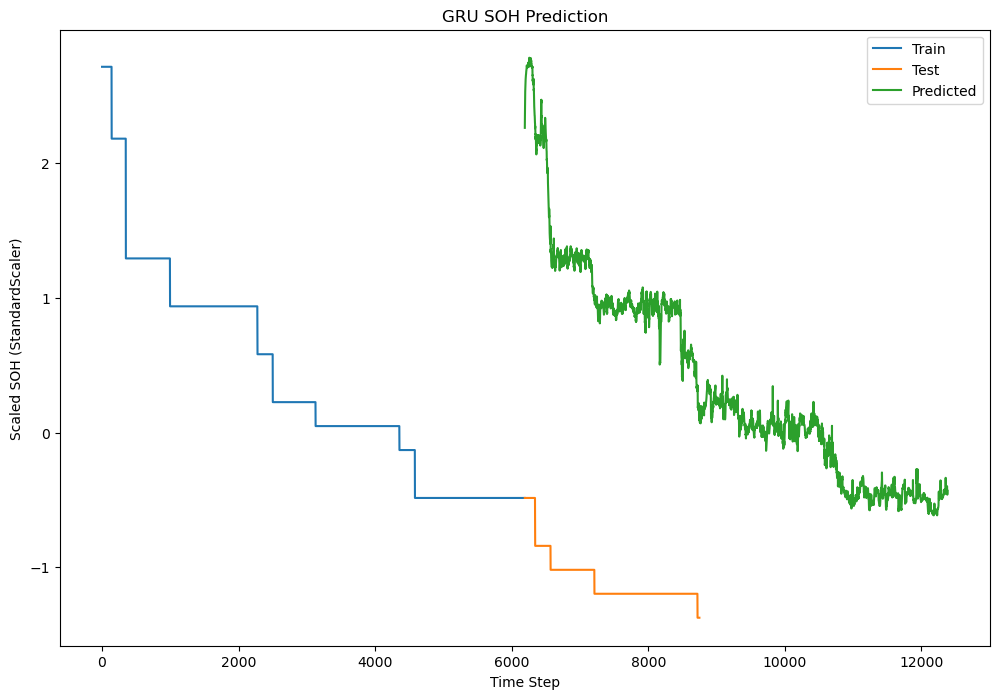

In [25]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

mse_loss = F.mse_loss(test_predictions, testY_tensor)
print(f'Mean Squared Error: {mse_loss.item():.4f}')

# 將預測值和真實值轉換回 NumPy 格式
train_np = trainY_tensor.cpu().numpy()
test_predictions_np = test_predictions.cpu().numpy()
testY_np = testY_tensor.cpu().numpy()

plt.figure(figsize=(12, 8))

plt.plot(train_np, label = 'Train')
plt.plot(range(len(train_np), len(train_np) + len(testY_np)), testY_np, label='Test')
plt.plot(range(len(train_np), len(train_np) + len(test_predictions_np)), test_predictions_np, label='Predicted')

plt.title('GRU SOH Prediction')
plt.xlabel('Time Step')
plt.ylabel('Scaled SOH (StandardScaler)')
plt.legend()
plt.show()

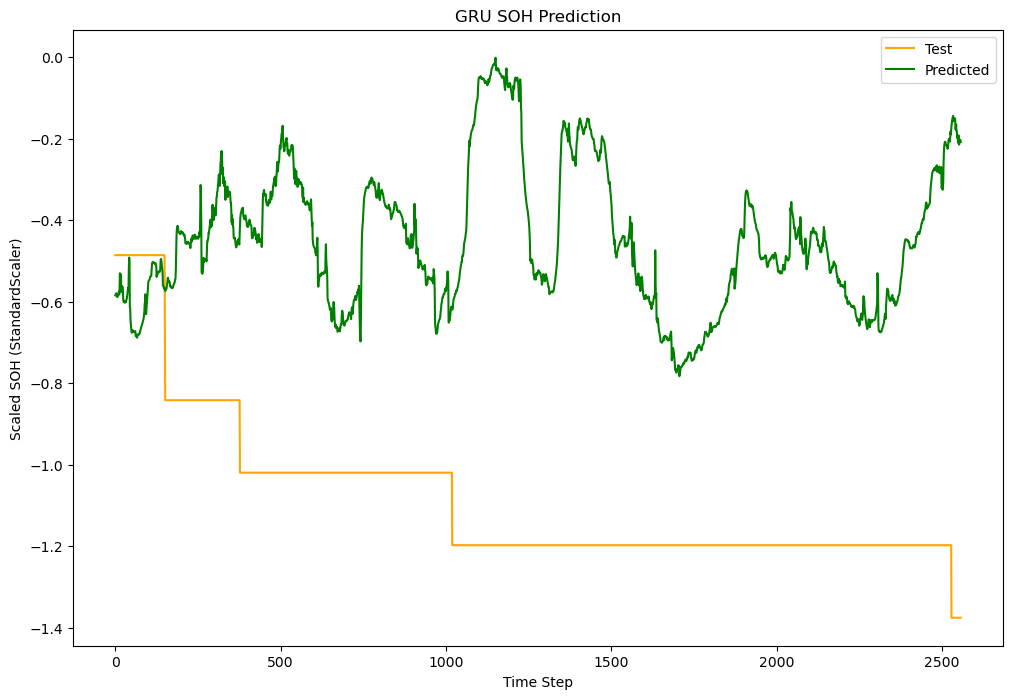

In [21]:
plt.figure(figsize=(12, 8))

plt.plot(testY_np, label='Test', color = 'orange')
plt.plot(test_predictions_np, label='Predicted', color = 'g')

plt.title('GRU SOH Prediction')
plt.xlabel('Time Step')
plt.ylabel('Scaled SOH (StandardScaler)')
plt.legend()
plt.show()

In [22]:
# torch.save(model, '../models/soh_gru64x5_1h_5946.pt')